> groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

https://disk.yandex.ru

> groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

https://disk.yandex.ru

> active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

https://disk.yandex.ru

> checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

https://disk.yandex.ru

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import json

In [2]:
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [3]:
def add_data(public_key):
    # 1.Создадим датафрейм на основе информации доступной по ссылке
    base_url='https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # 2. Реализуем, чтобы собиралась нужная нам ссылка
    url = base_url + urlencode((dict(public_key=public_key)))
    # 3. Тут не особо знаком с процессом, подсмотрел на ru.stackoverflow
    response = requests.get(url)
    data_url = response.json()['href']
    # 4. Создадим датафрейм с информацией из дополнительного файла по ссылке
    tab_groups_add = pd.read_csv(data_url, sep=';')
    
  
    # 5. Загрузим имеющиеся датафреймы
    # 5.1 Загрузим данные с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
    tab_groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_groups.csv', sep=";")
    # 5.2 Загрузим  данные с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
    tab_active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_active_studs.csv')
    # 5.2.1 Переименуем колонку с student_id на id
    tab_active_studs = tab_active_studs.rename(columns={'student_id':'id'})
    # 5.3 Загрузим данные с информацией об оплатах пользователей в дни проведения эксперимента.
    tab_checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_checks.csv', sep=";")
    # 5.3.1 Переименуем колонку с student_id на id
    tab_checks = tab_checks.rename(columns={'student_id':'id'})
    
    #tab_groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-ilenkov/Финальный проект/2_Вариант/Проект_2_group_add.csv', sep=",")

    # 6 Преоставим список строк для атрибутов столбца и присвом колонкам имена аналогичные в tab_groups
    # tab_groups_add.columns = ['id', 'grp']
    
    # 7 Удалим из tab_checks выбросы 
    # 7.1 Найдем пороговое значение 25% квантиля
    q1 = tab_checks.quantile(q=.25)
    # 7.2 Найдем пороговое значение 75% квантиля
    q3 = tab_checks.quantile(q=.75)
    # 7.2 Найдем межквартильный размах
    iqr = tab_checks.apply(stats.iqr)
    # 7.3 Перезапишем датафрейм, но уже без выбросов
    tab_checks = tab_checks[~((tab_checks < (q1-1.5*iqr)) | (tab_checks > (q3+1.5*iqr))).any(axis=1)]
    # 8 Соеденим два фрейма (с существующими данными - tab_groups и с добавленными - tab_groups_add)
    tab_group_all = pd.concat([tab_groups,tab_groups_add]).drop_duplicates().reset_index(drop=True)
    # 9 Соединим получившийся в п.8 датафрейм с tab_active_studs
    tab_active_all = tab_active_studs.merge(tab_group_all, how='left', on='id')
    # 10 Соединим получившийся в п.9 датафрейм с tab_checks - добавим информацию о платежах
    tab_active_all = tab_active_all.merge(tab_checks, how='left', on='id')
    # 11 Заменим значения с Nan На ноль
    tab_active_all = tab_active_all.fillna(0)
    # 12 Присвоим каждому id статус. Если не купил ничего - статус "pay_not", а если купил - статус "pay_yes"
    tab_active_all['status'] = tab_active_all['rev'].apply(lambda x: 'pay_yes' if x > 0 else 'pay_not' )
    # Получился финальный датафрейм, на данных из него рассчитываем метрики
    
    # 13 Рассчитаем метрики
    # 13.1 Рассчитаем ARPU
    arpu = tab_active_all.groupby('grp').agg({'rev':'mean'}).rename(columns={'rev':'arpu'}).round(2)
    # 13.2 Рассчитаем ARPPU
    arppu = tab_active_all.query('status=="pay_yes"').groupby('grp').agg({'rev':'mean'}).rename(columns={'rev':'arppu'}).reset_index().round(2)
    # 13.3 Рассчитаем CR
    quantity_yes = tab_active_all.query('status=="pay_yes"').groupby(['grp']).agg({'status': 'count'}).rename(columns={"status": "purchase_yes"}).reset_index()
    quantity_no = tab_active_all.query('status== "pay_not"').groupby(['grp']).agg({'status': 'count'}).rename(columns={"status": "purchase_no"}).reset_index()
    values = quantity_no.merge(quantity_yes, how='left', on='grp')
    values['cr'] = ((values.purchase_yes  / values.purchase_no) * 100).round(2)
    values = values.merge(arpu, how='left', on='grp')
    values= values.merge(arppu, how='left', on='grp')

    return values
    print()
    print('Группа А - контрольная группа.') 
    print('Группа B - экспериментальная группа (тестовая).')
    print('Колонка "purchase_no" - кол-во неоплат. Колонка "purchase_yes" - кол-во оплат.')

In [4]:
add_data(public_key)

,grp,purchase_no,purchase_yes,cr,arpu,arppu
0,0,12,1,8.33,146.15,1900.00
1,A,1457,78,5.35,47.44,933.59
2,B,6481,312,4.81,57.18,1244.95


In [5]:
def chart_metrics(values):
    # Применим функцию subplot из Matplotlib. Укажем область отрисовки (fig) и кол-во координатных осей (axes - 1,3 в коде)
    fig, axes = plt.subplots(1, 3,figsize=(15, 4) )
    # Создадим аргумент ax, который будет обращаться к индексу объекта axes - выводим нужный график в указанном порядке
    sns.barplot(data = values ,x='cr', y='grp', orient='h',ax=axes[0])
    # Присовим название каждому графику
    axes[0].set_title("СR")

    sns.barplot(data = values ,x='arpu', y='grp', orient='h', ax=axes[1])
    axes[1].set_title("ARPU")

    sns.barplot(data = values ,x='arppu', y='grp', orient='h', ax=axes[2])
    axes[2].set_title("ARPPU")

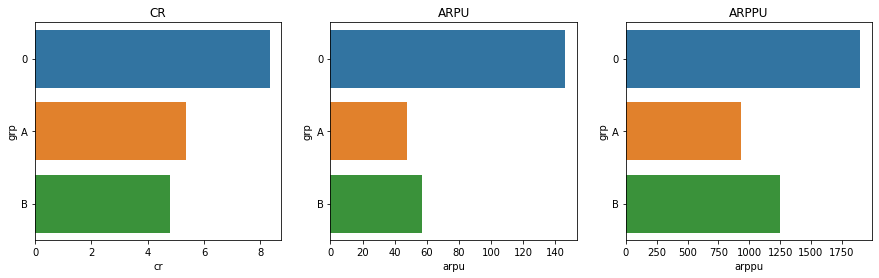

In [6]:
chart_metrics(add_data(public_key))